In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

# Ideas to study:
# Overall leading causes of death
# Death probability by age (extrapolate averages between ranges)
# Leading casuses by age group
# Is there a difference between the sexes? If so, at what age does this become aparent?
# What have we gotten better at? Worse at?
# Lead into provincial study if data is available

#Source: Stats Canada
df = pd.read_csv('.\\data\\deaths_canada.csv')
df = df[['REF_DATE','Age at time of death','Sex','Cause of death (ICD-10)','Characteristics','VALUE']]
df.rename(columns={'REF_DATE':'Year'}, inplace=True)
dfMort = df[df['Characteristics']=='Age-specific mortality rate per 100,000 population'].rename(columns={'VALUE':'Mortality rate per 100,000'}).drop(columns=['Characteristics'])
dfNum = df[df['Characteristics']=='Number of deaths'].rename(columns={'VALUE':'Number of deaths'}).drop(columns=['Characteristics'])
df = dfMort.merge(dfNum, left_on=['Year','Cause of death (ICD-10)','Age at time of death', 'Sex'], right_on=['Year','Cause of death (ICD-10)','Age at time of death', 'Sex'])

In [2]:
def breakOutCause(x):
    l = x.split("[")
    return l[0][:-1]

df = df[df['Cause of death (ICD-10)']!='Total, all causes of death [A00-Y89]'] #Remove the totals
df['Cause of death'] = df['Cause of death (ICD-10)'].apply(lambda x: breakOutCause(x))
df['Year'] = df['Year'].astype(int)
df['Age at time of death'] = df['Age at time of death'].str.replace("Age at time of death, ", "")
df.head()

,Year,Age at time of death,Sex,Cause of death (ICD-10),"Mortality rate per 100,000",Number of deaths,Cause of death
19,2000,under 1 year,Males,Salmonella infections [A01-A02],0.0,0.0,Salmonella infections
20,2001,under 1 year,Males,Salmonella infections [A01-A02],0.0,0.0,Salmonella infections
21,2002,under 1 year,Males,Salmonella infections [A01-A02],0.0,0.0,Salmonella infections
22,2003,under 1 year,Males,Salmonella infections [A01-A02],0.0,0.0,Salmonella infections
23,2004,under 1 year,Males,Salmonella infections [A01-A02],0.0,0.0,Salmonella infections


In [3]:
def ageGroup(x):
    if x == 'under 1 year':
        return "under 1 year"
    elif x in ['1 to 4 years', '5 to 9 years', '10 to 14 years']:
        return "1 to 14 years"
    elif x in ["15 to 19 years', '20 to 24 years', '25 to 29 years"]:
        return "15 to 29 years"
    elif x in ['30 to 34 years', '35 to 39 years', '40 to 44 years']:
        return "30 to 44 years"
    elif x in ['45 to 49 years', '50 to 54 years', '55 to 59 years']:
        return "45 to 59 years"
    elif x in ['60 to 64 years', '65 to 69 years', '70 to 74 years']:
        return "60 to 74 years"
    else:
        return "75+ years"
    
df = df[df['Age at time of death']!='not stated']
df['age group'] = df['Age at time of death'].apply(lambda x: ageGroup(x))

In [4]:
def replaceCause(x):
    if x =="Other and unspecified infectious and parasitic diseases and their sequela":
        return "Other*"
    elif x== "In situ neoplasms, benign neoplasms and neoplasms of uncertain or unknown behaviour":
        return "Uncertain neoplasms*"
    elif x=="Congenital malformations, deformations and chromosomal abnormalities":
        return "chromosomal abnormalities*"
    elif x=="Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified":
        return "Abnormal findings*"
    elif x=="Certain conditions originating in the perinatal period":
        return "perinatal conditions*"
    elif x=="Cholelithiasis and other disorders of gallbladder":
        return "Cholelithiasis*"
    else:
        return x
    
df['Cause of death'] = df['Cause of death'].apply(lambda x: replaceCause(x))

## Causes of death over time

Other*: Other and unspecified infectious and parasitic diseases and their sequela
Uncertain neoplasms*: In situ neoplasms, benign neoplasms and neoplasms of uncertain or unknown behaviour
chromosomal abnormalities*: Congenital malformations, deformations and chromosomal abnormalities
Abnormal findings*: Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified
Perinatal conditions*: Certain conditions originating in the perinatal period
Cholelithiasis*: Cholelithiasis and other disorders of gallbladder


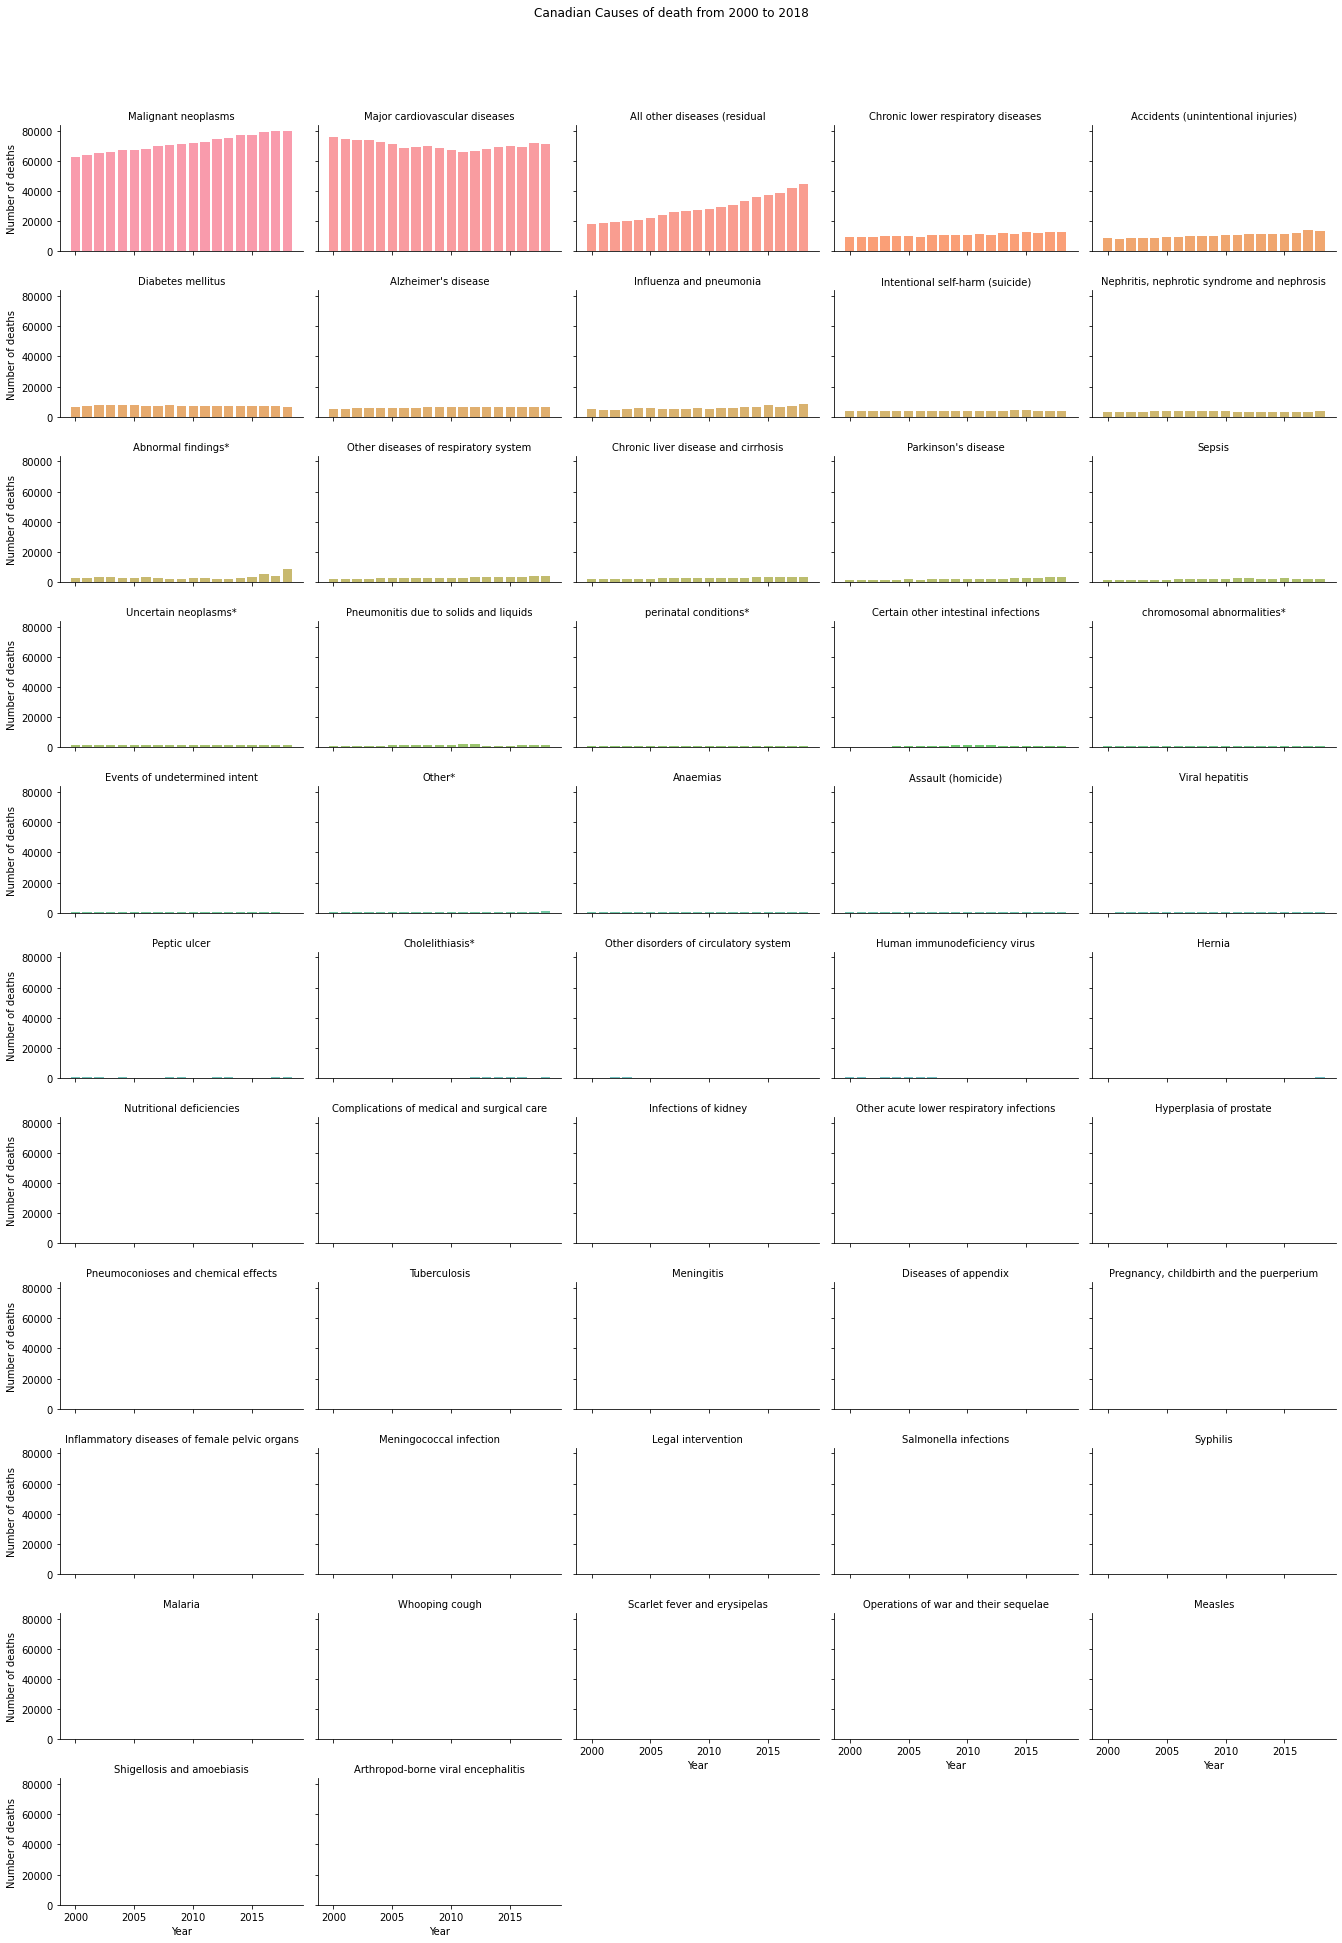

In [5]:
# Find leading causes of death, and order the graphing dataframe in that way
dfLead = df[df['Number of deaths']>0].groupby('Cause of death')['Number of deaths'].sum().sort_values(ascending=False).reset_index()
lOrder = list(dfLead['Cause of death'])
dfSum = df[df['Number of deaths']>0].groupby(['Year','Cause of death'])['Number of deaths'].sum().reset_index().sort_values(by=['Number of deaths'], ascending=False)

dfGraph = pd.DataFrame()

for l in lOrder:
    dfGraph = pd.concat([dfGraph,dfSum[dfSum['Cause of death']==l].reset_index()])
    
# Plot the grids
g = sns.FacetGrid(dfGraph, col='Cause of death', hue='Cause of death', col_wrap=5, height=2.5, aspect=1.5)
g = g.map(plt.bar, 'Year', 'Number of deaths', alpha=0.7).set_titles("{col_name}")
g = g.set_titles("{col_name}")

plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Canadian Causes of death from 2000 to 2018')

renameStr = "Other*: Other and unspecified infectious and parasitic diseases and their sequela\nUncertain neoplasms*: In situ neoplasms, benign neoplasms and neoplasms of uncertain or unknown behaviour\nchromosomal abnormalities*: Congenital malformations, deformations and chromosomal abnormalities\nAbnormal findings*: Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified\nPerinatal conditions*: Certain conditions originating in the perinatal period\nCholelithiasis*: Cholelithiasis and other disorders of gallbladder"
print(renameStr)

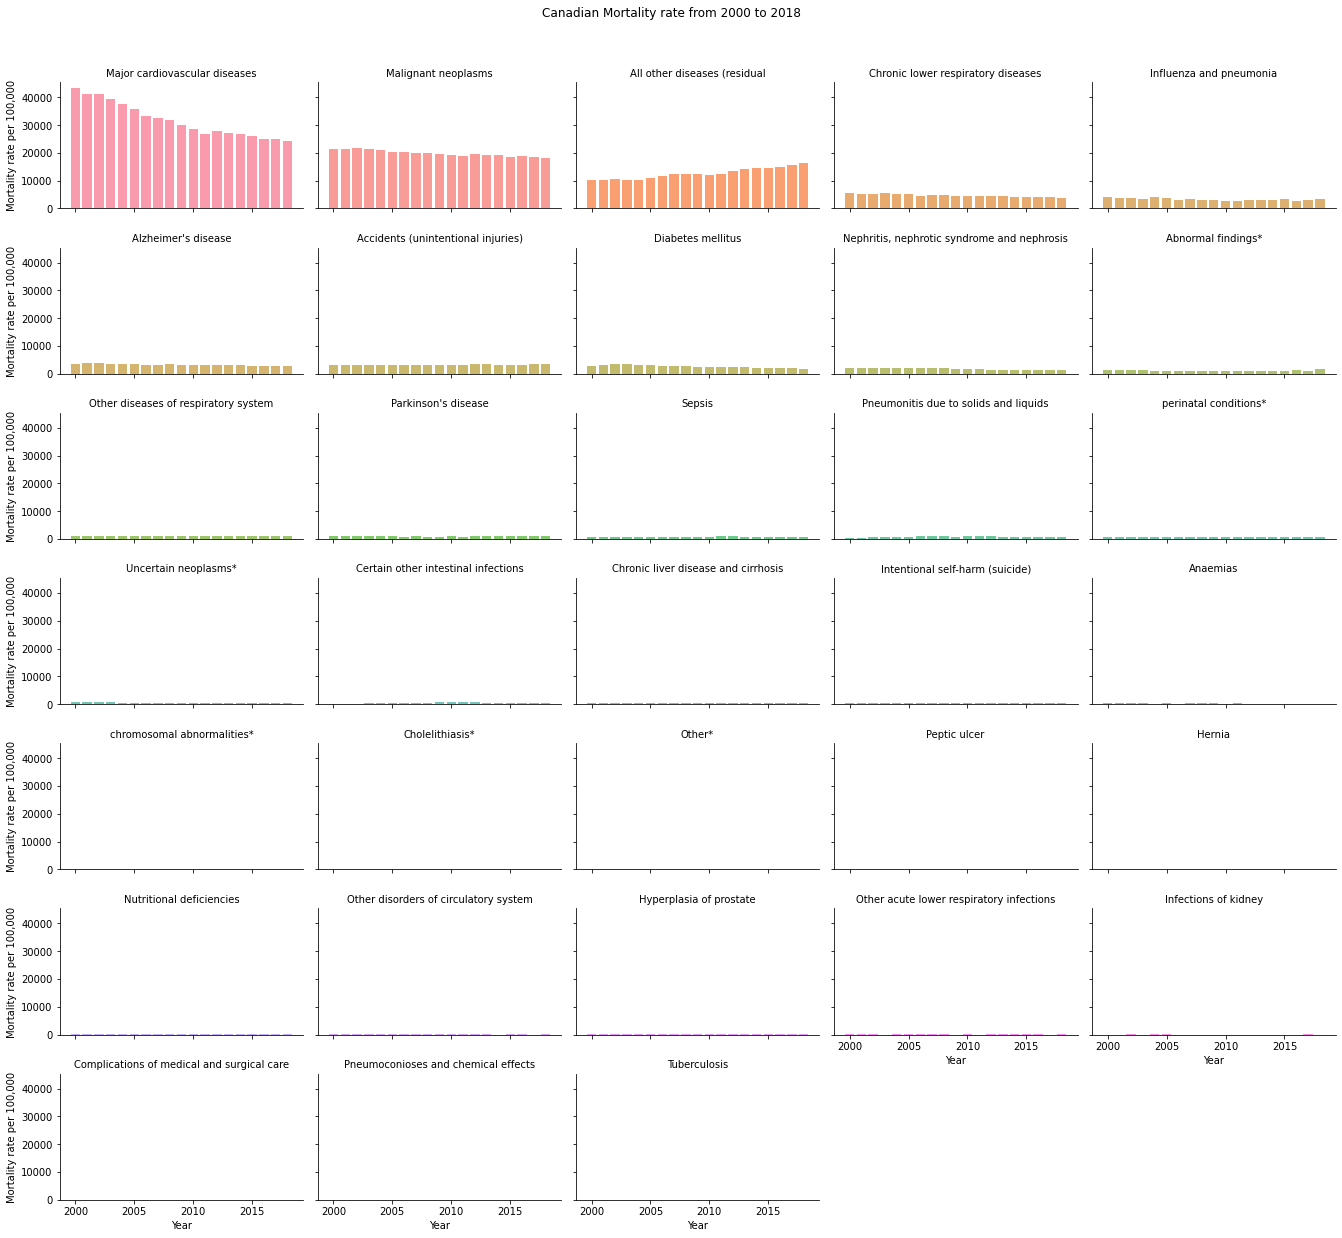

In [6]:
# Find leading Mortality rates, and order the graphing dataframe in that way
dfLead = df[df['Mortality rate per 100,000']>10].groupby('Cause of death')['Mortality rate per 100,000'].sum().sort_values(ascending=False).reset_index()
lOrder = list(dfLead['Cause of death'])
dfSum = df[df['Mortality rate per 100,000']>10].groupby(['Year','Cause of death'])['Mortality rate per 100,000'].sum().reset_index().sort_values(by=['Mortality rate per 100,000'], ascending=False)

dfGraph = pd.DataFrame()

for l in lOrder:
    dfGraph = pd.concat([dfGraph,dfSum[dfSum['Cause of death']==l].reset_index()])
    
# Plot the grids
g = sns.FacetGrid(dfGraph, col='Cause of death', hue='Cause of death', col_wrap=5, height=2.5, aspect=1.5)
g = g.map(plt.bar, 'Year', 'Mortality rate per 100,000', alpha=0.7).set_titles("{col_name}")
g = g.set_titles("{col_name}")

plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Canadian Mortality rate from 2000 to 2018')

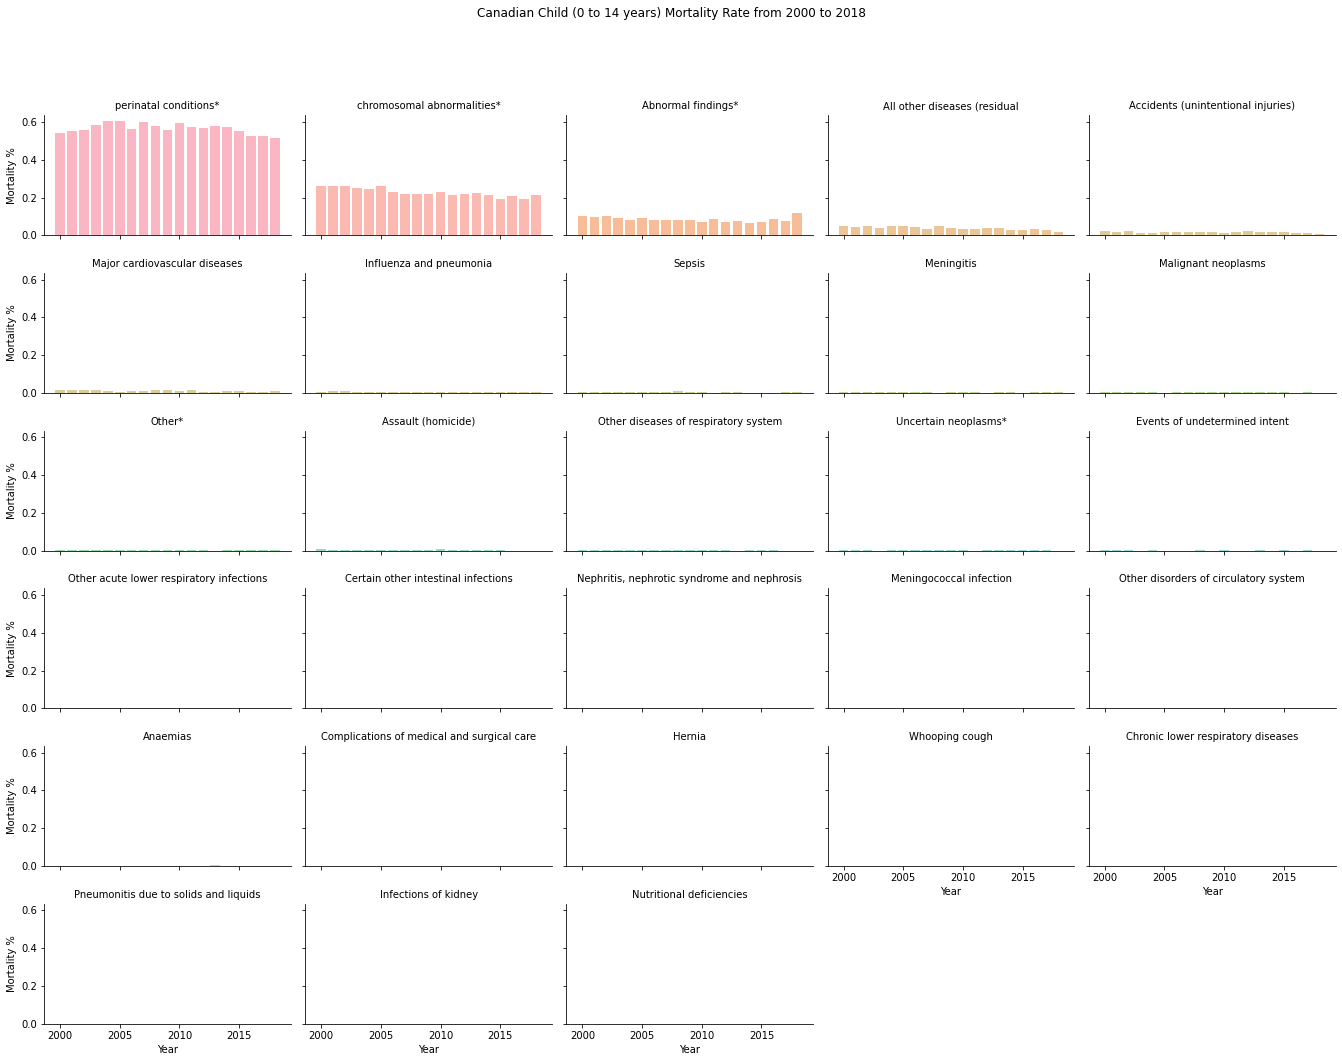

In [7]:
# Find leading Mortality rates, and order the graphing dataframe in that way
dfLead = df[(df['Mortality rate per 100,000']>0) & (df['Age at time of death'] == 'under 1 year')].groupby('Cause of death')['Mortality rate per 100,000'].sum().sort_values(ascending=False).reset_index()
lOrder = list(dfLead['Cause of death'])
dfSum = df[(df['Mortality rate per 100,000']>0) & (df['Age at time of death'] == 'under 1 year')].groupby(['Year','Cause of death'])['Mortality rate per 100,000'].sum().reset_index().sort_values(by=['Mortality rate per 100,000'], ascending=False)

dfSum['Mortality rate per 100,000'] = dfSum['Mortality rate per 100,000'] / 1000
dfSum.rename(columns={"Mortality rate per 100,000":"Mortality %"}, inplace=True)
dfSum = dfSum[dfSum['Mortality %']>0.001]

dfGraph = pd.DataFrame()

for l in lOrder:
    dfGraph = pd.concat([dfGraph,dfSum[dfSum['Cause of death']==l].reset_index()])
    
# Plot the grids
g = sns.FacetGrid(dfGraph, col='Cause of death', hue='Cause of death', col_wrap=5, height=2.5, aspect=1.5)
g = g.map(plt.bar, 'Year', 'Mortality %', alpha=0.5).set_titles("{col_name}")
g = g.set_titles("{col_name}")

plt.subplots_adjust(top=.88)
g = g.fig.suptitle('Canadian Child (0 to 14 years) Mortality Rate from 2000 to 2018')

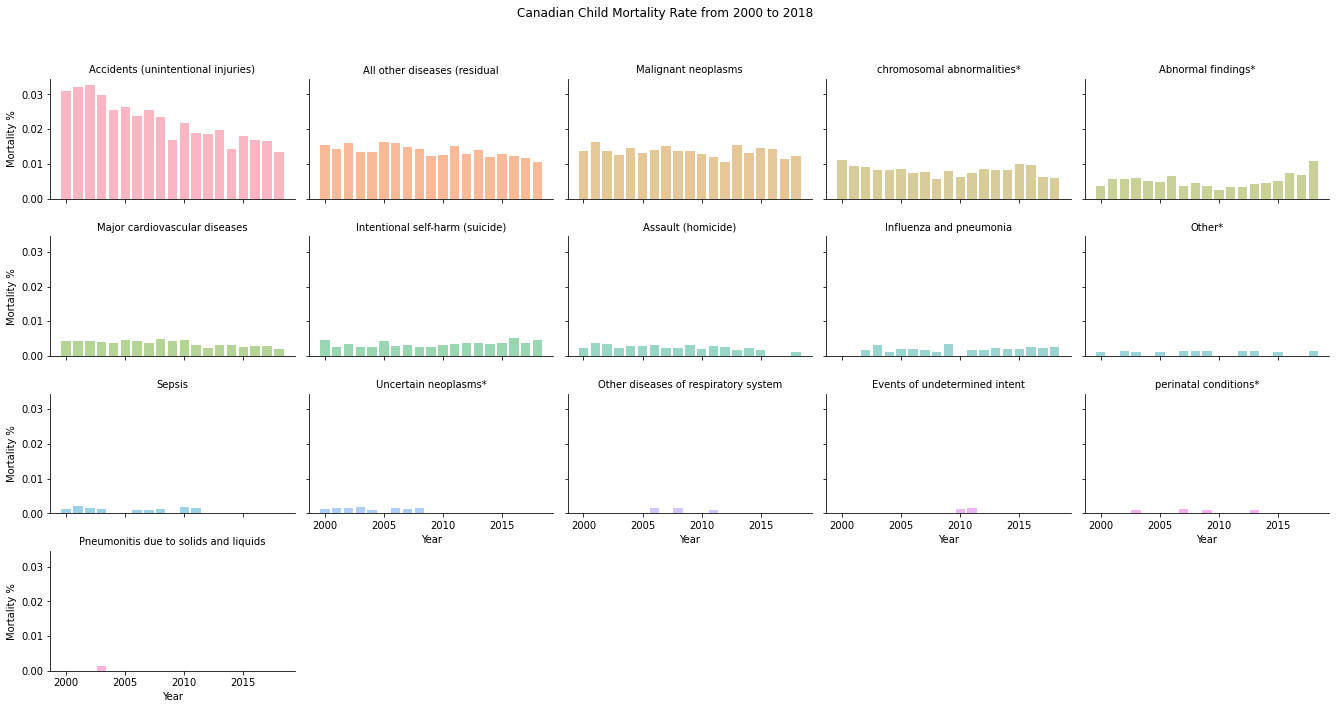

In [8]:
# Find leading Mortality rates, and order the graphing dataframe in that way
dfLead = df[(df['Mortality rate per 100,000']>0) & (df['Age at time of death'].isin(['1 to 4 years', '5 to 9 years', '10 to 14 years'])==True)].groupby('Cause of death')['Mortality rate per 100,000'].sum().sort_values(ascending=False).reset_index()
lOrder = list(dfLead['Cause of death'])
dfSum = df[(df['Mortality rate per 100,000']>0) & (df['Age at time of death'].isin(['1 to 4 years', '5 to 9 years', '10 to 14 years'])==True)].groupby(['Year','Cause of death'])['Mortality rate per 100,000'].sum().reset_index().sort_values(by=['Mortality rate per 100,000'], ascending=False)

dfSum['Mortality rate per 100,000'] = dfSum['Mortality rate per 100,000'] / 1000
dfSum.rename(columns={"Mortality rate per 100,000":"Mortality %"}, inplace=True)
dfSum = dfSum[dfSum['Mortality %']>0.001]

dfGraph = pd.DataFrame()

for l in lOrder:
    dfGraph = pd.concat([dfGraph,dfSum[dfSum['Cause of death']==l].reset_index()])
    
# Plot the grids
g = sns.FacetGrid(dfGraph, col='Cause of death', hue='Cause of death', col_wrap=5, height=2.5, aspect=1.5)
g = g.map(plt.bar, 'Year', 'Mortality %', alpha=0.5).set_titles("{col_name}")
g = g.set_titles("{col_name}")

plt.subplots_adjust(top=.88)
g = g.fig.suptitle('Canadian Child Mortality Rate from 2000 to 2018')

Once you remove children under 1 years old, you see Accidents jump to the top, but fortunately, they have been on a steep decline since 2000

In [9]:
def buildSentence(cause):
    ''' Builds a sentence surrounding a specific cause of death
    INPUT: the cause of death to be expounded on
    OUPPUT: a sentence to print
    '''
    dfS = dfSum[dfSum['Cause of death']==cause]
    peak = dfS['Mortality %'].max()
    peakYear =  dfS.sort_values('Mortality %', ascending=False).head(1)['Year'].max()
    mort2018 = dfS[dfS['Year']==2018]['Mortality %'].sum()
    
    if np.isnan(peak):
        return ''
    
    if mort2018 < peak:
        s = '{} peaked at {}% morality in {}, but declined to {}% in 2018'.format(cause,round(peak, 3),peakYear,round(mort2018, 3))
    else:
        s = '{} peaked at {}% morality in 2018'.format(cause,round(peak, 3))
    
    return s

print("The overall mprtality % for children aged 1 to 14 years in 2018 is {} % or {} deaths".format(round(dfSum[dfSum['Year']==2018]['Mortality %'].sum(), 3),df[(df['Age at time of death'].isin(['1 to 4 years', '5 to 9 years', '10 to 14 years'])==True) & (df['Year']==2018)]['Number of deaths'].sum().astype(int)))

for l in lOrder:
    st = buildSentence(l)
    if st !='':
        print(st)

The overall mprtality % for children aged 1 to 14 years in 2018 is 0.065 % or 632 deaths
Accidents (unintentional injuries) peaked at 0.033% morality in 2002, but declined to 0.014% in 2018
All other diseases (residual peaked at 0.016% morality in 2005, but declined to 0.01% in 2018
Malignant neoplasms peaked at 0.016% morality in 2001, but declined to 0.012% in 2018
chromosomal abnormalities* peaked at 0.011% morality in 2000, but declined to 0.006% in 2018
Abnormal findings* peaked at 0.011% morality in 2018
Major cardiovascular diseases peaked at 0.005% morality in 2008, but declined to 0.002% in 2018
Intentional self-harm (suicide) peaked at 0.005% morality in 2016, but declined to 0.005% in 2018
Assault (homicide) peaked at 0.004% morality in 2001, but declined to 0.001% in 2018
Influenza and pneumonia peaked at 0.003% morality in 2009, but declined to 0.003% in 2018
Other* peaked at 0.002% morality in 2009, but declined to 0.001% in 2018
Sepsis peaked at 0.002% morality in 2001, 

## As you age, what percentage of the Canadians have you outlived?

In [10]:
dfma = df[(df['Year']==2018) & (df['Mortality rate per 100,000']!= 0)][['Sex','Mortality rate per 100,000','Cause of death', 'Age at time of death', 'Number of deaths']]
dfma.rename(columns={'Mortality rate per 100,000':'mortality', 'Cause of death': 'cause', 'Age at time of death':'age'}, inplace=True)
dfma['mortality'] = dfma['mortality'] / 1000

def getAgeStart(x):
    s = x.split(' ')[0]
    if s == 'under':
        return 0
    else:
        return int(s)

dfma['agePlot'] = dfma['age'].apply(lambda x: getAgeStart(x))
dfma = dfma[['Sex','mortality','cause','agePlot', 'Number of deaths']]

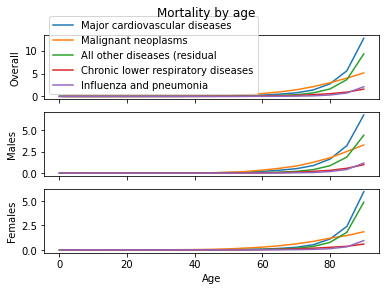

In [11]:
causes = dfma.groupby(['cause'])['mortality'].sum().reset_index().sort_values('mortality',ascending=False)['cause'].head()

fig, axs = plt.subplots(3)
fig.suptitle('Mortality by age')
plt.rcParams["figure.figsize"] = (8,8)

for l in causes:
    axs[0].plot(dfma[dfma['cause']==l].groupby('agePlot')['mortality'].sum(), label=l)
    axs[1].plot(dfma[(dfma['cause']==l) & (dfma['Sex']=='Males')].groupby('agePlot')['mortality'].sum())
    axs[2].plot(dfma[(dfma['cause']==l) & (dfma['Sex']=='Females')].groupby('agePlot')['mortality'].sum())
        
axs[0].set(ylabel='Overall')
axs[1].set(ylabel='Males')
axs[2].set(ylabel='Females')

for ax in axs.flat:
    ax.set(xlabel='Age')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
axs[0].legend()
plt.show();

In [12]:
def rollingMortality(x, dfr=dfr):
    return dfr[dfr['agePlot'] <= x]['mortality'].sum()

def rollingDeaths(x,dfr=dfr):
    return dfr[dfr['agePlot'] <= x]['Number of deaths'].sum()

dfr = dfma.groupby('agePlot')['mortality', 'Number of deaths'].sum().reset_index()
dfr['rolling mortality'] = dfr['agePlot'].apply(lambda x: rollingMortality(x))
dfr['rolling deaths'] = dfr['agePlot'].apply(lambda x: rollingDeaths(x))
dfr.rename(columns={'agePlot':'Age', 'mortality':'% chance that you will die over the next 5 years', 'rolling mortality': '% of this age group that have died'}, inplace=True)
dfr

NameError: name 'dfr' is not defined